# Deep learning with standard Python

Here, we will be traing a deep learning model with only Python. The only 3rd party libary I will be using is matplotlib to show images. This is my first neural net I wrote. If you see some kind of error, please let me know through this email: shipalnomoo at gmail.com. This is a quick hands on exercise. Rather than focusing on theory, this is more hands on to feel what it is to train a model. we will explore what it means to train a model using MNIST handwritten dataset. When I was reading a [blog post](https://sgugger.github.io/a-simple-neural-net-in-numpy.html#a-simple-neural-net-in-numpy) from Sylvain Gugger called, "A simple neural net in numpy," I found it interesting and wanted to try to write my version in standard Python. 

There are many libraries used for deep learning, such as Tensorflow and Keras, Pytorch, Scikit-Learn, numpy, and others. However, in order to understand basic concept of deep learning, we do no need to use any of these tools. 

Here are Python libraries I will be using. Other than matplotlib, all libraries are here:

In [109]:
import gzip                             # Converting zip into python objects
import matplotlib.pyplot as plt         # Library for showing images
import random                           # Initializing random weights
import statistics                       # Getting mean or stdev
import math                             # Exponential function
import operator as op                   # just algebraic operators such as +, -, *, /
import time                             # Timing for performance
from functools import reduce

## Utilities

This section can be skipped as you can understand how deep learning works without understanding how these utilities work. You can consider these as built-in functions or machine language blobs. Simply fold the heading and run it.

If you decided to dig into lower level of deep learning, let's begin. Because we are only using python lists, we need to build utilities or tools we need in order to train our model. With other fancy libraries, these are built-in. However, because we are building up from scratch, we start with those basic utilities that we will use later on. How these are implemented specifically are not important at all for our purpose of understanding how deep learning works. As long as you get the general idea of what these functions do, that is good enough. However, please do not just run those cells without thinking about what they will return in advance if you want to understand more. Give yourself couple seconds to think and come up with output in your head. This will change your level of understanding.

With those low level functions, we will build up abstraction layers. First, I start with `shape`, which returns a tuple of shape of a matrix or a list.

In [110]:
def shape(matrix) -> tuple:
    """ 
    Get a shape of a matrix 
    """
    def loop(mat, result):
        if not isinstance(mat, list):
            return result
        else:
            return loop(mat[0], result + (len(mat),))
    return loop(matrix, tuple())

In [111]:
shape([1, 2])

(2,)

In [112]:
shape([[1, 2, 3],
       [4, 5, 6]])

(2, 3)

In [113]:
shape([[[1, 2],
        [3, 4]]])

(1, 2, 2)

It would be better if we can make matrices easier instead of making them by hand.

In [114]:
def lst_nums(shape:tuple, num:int=1) -> list:
    """ 
    Return a list of shape filled with num. 
    Default value for num is 1 
    """
    if isinstance(shape, tuple):
        x, y = shape
        return [[num]*y for _ in range(x)]
    else:
        x = shape
        return [num]*x

In [115]:
lst_nums(1, 1)

[1]

In [116]:
hund_1s = lst_nums((10, 10), 1)
len(hund_1s), len(hund_1s[0])

(10, 10)

In [117]:
hund_1s

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

Here is a transpose function, which transposes a matrix. If you are not familiar with what it does, here is a [wikipedia](https://en.wikipedia.org/wiki/Transpose) page with an animation.

In [118]:
def transpose (mat) -> list:
    """
    Transpose the matrix
    """
    return [[m[i] for m in mat] for i in range(len(mat[0]))]

In [119]:
mat1 = [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]

In [120]:
mat1

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

In [121]:
transpose(mat1)

[[1, 4, 7], [2, 5, 8], [3, 6, 9]]

`map_mat` calls a fn (function) to a mat1 if there is only one matrix. If there are two matrices, it uses individual elements from both mat1 and mat2 as arguments for the fn. This is a long and complicated function, and I don't think I did a good job of writing it. It might be better to divide them by smaller functions, but I'm not sure. How would you improve it?

In [122]:
def map_mat(fn, mat1, mat2=None) -> list:
    """ 
    If there is only one matrix, call the function on the matrix.
    If map_mat is called with two matrices, call the function with 
    individual elements from mat1 and mat2 respectfully. 
    This function can handle broadcasting when mat2 is a vector. 
    """
    if mat2 == None:
        return [list(map(fn, mat1[i])) for i in range(len(mat1))]
    mat = []
    try: 
        m1r,m1c = shape(mat1)
    except ValueError: 
        m1r = shape(mat1)[0]
        m1c = 0
    try: 
        m2r,m2c = shape(mat2)
    except ValueError: 
        m2r = shape(mat2)[0]
        m2c = 0
    if m1c == m2c == 0:                     # Two 1D vectors
        return list(map(fn, mat1, mat2))
    elif (m1r, m1c) == (m2r, m2c):          # two matrixs with same sizes
        return [[fn(x,y) for x,y in zip(mat1[i], mat2[i])] for i in range(len(mat1))]
    elif m1c == m2r and m2c==0:             # shape of (a, b), (b,)
        for i in range(m1r):
            mat.append([fn(x,y) for x,y in zip(mat1[i],mat2)])
        return mat
    elif m1r == m2r and m2c == 0:           # shape of (a, b), (a,)
        for i in range(m1r):
            mat.append([fn(m, mat2[i]) for m in mat1[i]])
        return mat
    else:
        raise Exception("map_mat error")

In [123]:
hund_2s = lst_nums((10, 10), 2)

In [124]:
hund_3s = map_mat(lambda x, y: x+y, hund_1s, hund_2s)
hund_3s

[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]

In [125]:
map_mat(op.mul, hund_3s, hund_3s)

[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]

In [126]:
map_mat(lambda x: x + 1, mat1)

[[2, 3, 4], [5, 6, 7], [8, 9, 10]]

Next, we have `reshape` function, which reshapes a matrix into new_shape.

In [127]:
def reshape(matrix, new_shape) -> list:
    """ 
    If matrix can be reshaped into new_shape, then
    return a new matrix with a respective shape. 
    """
    old_shape = shape(matrix)
    elem_nums = mul(old_shape)
    if old_shape == new_shape:
        return matrix
    elif not elem_nums == mul(new_shape):
        raise Exception("Wrong shape!")
    else:
        return shaping(flatten(matrix), new_shape, elem_nums)

In [128]:
def mul(lst: list) -> int:
    """ 
    Return a result of all numbers multiplied.
    Like sum, but multiplying. 
    """
    return reduce(op.mul, lst, 1)

In [129]:
def shaping(flat, new_shape, elem_nums):
    """ 
    Actually shaping flat array into new shape. 
    """
    new_shape_len = len(new_shape)
    if new_shape_len == 1 or new_shape_len == 0:
        return result
    div = elem_nums // new_shape[0] # div = 50
    result = [flat[(i * div):((i+1) * div)] for i in range(new_shape[0])]
    if new_shape_len == 2:
        return result
    else:
        return [shaping(result[i], new_shape[1:], div) for i in range(new_shape[0])]

In [130]:
def flatten(matrix):
    """ 
    Flatten a matrix into a 1 dimensional list. 
    """
    result = []
    for i in range(len(matrix)):
        if isinstance(matrix[i], list):
            result.extend(flatten(matrix[i]))
        else:
            result.append(matrix[i])
    return result

Testing new tools 

In [131]:
# Reshape works with shape function.
shape(reshape(hund_1s, (100, 1))), shape(reshape(hund_1s, (1, 100)))

((100, 1), (1, 100))

In [132]:
shape(reshape(hund_1s, (2, 5, 10)))

(2, 5, 10)

In [133]:
mat3 = [[[1, 2],
         [3, 4]],
        [[5, 6],
         [7, 8]]]
mat3, shape(mat3)

([[[1, 2], [3, 4]], [[5, 6], [7, 8]]], (2, 2, 2))

In [134]:
shape(reshape(mat3, (4, 2))), reshape(mat3, (4, 2))

((4, 2), [[1, 2], [3, 4], [5, 6], [7, 8]])

## Collecting Data

With those utilities, we can get started on getting our hands dirty with deep learning.

First, we need data if we want to do some training. We are using [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains handwritten digits, from Yann Lecun website. The dataset has 60,000 training images and 10,000 testing images. When we look at amazing things computers were trained to do, such as self driving cars and speech recognition, there were actually a lot of data fed into them for training. Although we tend to only give credits to those who came up with state of the art models, nothing could have been possible without those who prepared for data. 

In [135]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2021-09-04 22:45:15--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2021-09-04 22:45:15 (88.0 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2021-09-04 22:45:15--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===========

In [136]:
!ls

data	     t10k-images-idx3-ubyte.gz	train-images-idx3-ubyte.gz
sample_data  t10k-labels-idx1-ubyte.gz	train-labels-idx1-ubyte.gz


Now, I am making a directory for all the data and putting data inside.

In [137]:
# Todo: Change the code into using python pathlib library 
!mkdir data
!mv train-images-idx3-ubyte.gz data/
!mv train-labels-idx1-ubyte.gz data/
!mv t10k-images-idx3-ubyte.gz data/
!mv t10k-labels-idx1-ubyte.gz data/
!ls data/

mkdir: cannot create directory ‘data’: File exists
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


Now, we have files we need. With `py_mnist_images` and `py_mnist_labels`, we convert these files into lists of images. I got those functions from [here](https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python), which originally returned numpy arrays, but I changed them to return lists. After calling those functions, we call `reshape` function to make them shapes of images, which are 28 by 28 pixels.

In [138]:
def py_mnist_images(fname:str, pct=1) -> list:
    """ 
    Convert zip files into lists of images. 
    Only returning pct percent of data.     
    """
    with gzip.open('data/'+fname, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # image_count = int(image_count * percent)
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = reshape(list(image_data), (image_count, column_count, row_count))
        return images[:int(image_count * pct)]
        # return reshape(images, (image_count, column_count, row_count))

def py_mnist_labels(fname:str, pct=1) -> list:
    """ 
    Convert zip files into lists of labels. 
    Only returning pct percent of data.     
    """
    with gzip.open('data/'+fname, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = list(label_data)
        return labels[:int(label_count * pct)]

With `py_mnist_images`, we get lists of images. We call these matrices. When an array has 1 dimension, it is a vector, and an array 2 or more dimensions is called matrix. 

Let's use only 1% of the data because python is slow. 

In [139]:
train_imgs = py_mnist_images('train-images-idx3-ubyte.gz', pct=0.01)
train_labels = py_mnist_labels('train-labels-idx1-ubyte.gz', pct=0.01)
test_imgs = py_mnist_images('t10k-images-idx3-ubyte.gz', pct=0.01)
test_labels = py_mnist_labels('t10k-labels-idx1-ubyte.gz', pct=0.01)

Let's take a look at those data before we move on. We want to make sure we are working with correct data. Using `plt.imshow`, we can take a look at each image.

In [140]:
type(train_imgs), type(train_imgs[0][0][0])

(list, int)

In [141]:
shape(train_imgs), shape(train_labels), shape(test_imgs), shape(test_labels)

((600, 28, 28), (600,), (100, 28, 28), (100,))

Here are pictures with labels. 

5

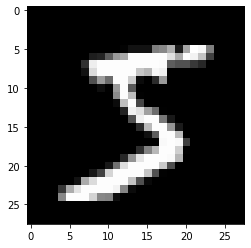

In [142]:
plt.imshow(train_imgs[0], cmap='gray'); train_labels[0]

0

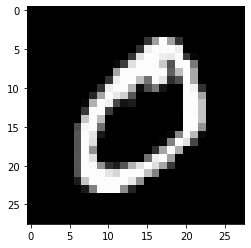

In [143]:
plt.imshow(train_imgs[1], cmap='gray'); train_labels[1]

4

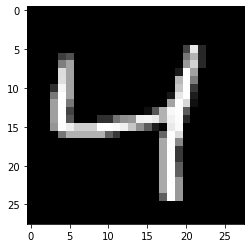

In [144]:
plt.imshow(train_imgs[2], cmap='gray'); train_labels[2]

Now that we have some tools to work with, we can prepare our data for training. First, we will reshape our data. We are combining x and y axis into a vector (1-dimensional array) so that one array equals to one image. Then, we normalize our data by dividing them by 255 because the highest value is 255. 

In [145]:
train_imgs = reshape(train_imgs, (600, 28 * 28))
test_imgs = reshape(test_imgs, (100, 28 * 28))
shape(train_imgs), shape(test_imgs)

((600, 784), (100, 784))

In [146]:
train_imgs = map_mat(lambda x: x / 255, train_imgs)
test_imgs = map_mat(lambda x: x / 255, test_imgs)

## Initializing Weights and Biases

Now that we have data, we need weights and biases. We can just think of these as matrices of random numbers. By training models, we are trying to change these random numbers into right ones that will give us good results. 

In [147]:
def lst_random(shape, init_parms=False):
    """
    return a list of randoms and if init_parms is True, 
    initialize parameters using Kaiming init.
    """
    x, y = shape
    res = lst_nums(shape, 0)
    for i in range(x):
        for j in range(y):
            res[i][j] = random.normalvariate(0,1)
            if init_parms: res[i][j] *= math.sqrt(2/x)
    return res

In [148]:
rand_mat = lst_random((10,10))
shape(rand_mat)

(10, 10)

With Kaiming initialization, we can train deeper models.

In [149]:
sample = lst_random((200, 100), True)
# x = map_mat(lambda x: x*0.1, x)
# statistics.stdev(x[0])

Checking whether the initialization works. Standard deviation should equal to sqrt(2/n_in), and mean should be 0. And this works. With this initialization, we can train deeper layers. For more information, paper is [here](https://arxiv.org/abs/1502.01852).

In [150]:
def check_dist(x):
    for i in range(len(x)//10):
        print(statistics.stdev(x[i]), statistics.mean(x[i]))

In [151]:
math.sqrt(2/200)

0.1

In [152]:
check_dist(sample)

0.09403171521976275 0.013622055097298417
0.11022747597801236 0.004275158318235466
0.10391848009119782 -0.01736304265045632
0.10158040902814837 -0.02140397506068278
0.09882006911891293 -0.0053818314803667595
0.10310174401159848 0.000929601684799433
0.10590896519472498 -0.002986448136461439
0.10860384191536261 -0.0019467197654269364
0.10334640758604192 0.00022377121525137602
0.10250798204880954 -0.005277651317013858
0.09689419991073889 -0.011304377462247831
0.10161001000236593 0.0012921971242199144
0.10496614902299435 0.01890044117944085
0.10825130611808448 0.0014377722556012744
0.09529078477492108 -0.012941433333789797
0.09452227869299638 0.0011131585828455986
0.10649544360871815 -0.014153836025424677
0.10728331890142034 0.011419162266351656
0.09875726811080487 -0.008044575164524132
0.10548583913595076 0.001835162672406242


## Matrix multiplication

Now that our data is ready, it is time to look at matrix multiplication, which is the most frequently used operation in deep learning.

Here is my implementation of matrix multiplication. There are other ways to do it, but I found this to be the fastest so far.

In [153]:
m1 = [[1, 2], [3, 4]]
m2 = [[5, 4], [3, 2]]

In [154]:
def py_matmul(a, b):
    """ 
    Matrix multiplication 
    """
    ar,ac = len(a),len(a[0])
    br,bc = len(b),len(b[0])
    assert ac == br, f'Size of ar ({ac}) does not match br ({br}).'
    c = lst_nums((ar, bc), 0)
    t = transpose(b)
    for i in range(ar):
        c[i] = [sum(map(op.mul, a[i], t[j])) for j in range(bc)]
    return c

In [155]:
py_matmul(m1, m2)

[[11, 8], [27, 20]]

## Model

It is time to make a model to train. Let's briefly look at what they do. Each function has a forward pass and a backward pass. Backward pass finds gradients and allows us to use stochastic gradient descent (SGD). Stochastic gradient descent is how we can train our model automatically and get our random weights and biases closer to right numbers that will suit to our needs. 

Relu turns negative number into zeros. 

In [156]:
class Relu():
    def forward(self, x):
        self.old_x = x.copy()
        res = map_mat(lambda y: 0 if y < 0 else y, x)
        return res

    def backward(self, grad):
        res = map_mat(lambda x, g: g if x > 0 else 0, self.old_x, grad)
        return res

Softmax is used when there are many categories to predict. Our data has to predict ten categories, from zero to ten. 

In [157]:
class Softmax():
    def forward(self, inp):
        mat = map_mat(math.exp, inp)
        self.old_y = []
        for i in range(len(mat)):
            s = sum(mat[i])
            self.old_y.append([x/s for x in mat[i]])
        return self.old_y
    
    def backward(self, grad):
        res = map_mat(op.mul, self.old_y, grad)
        res = [sum(res[i]) for i in range(len(self.old_y))] # shape is (64,)
        return map_mat(op.mul, self.old_y, map_mat(op.sub, grad, res))

Cross entropy loss measures how well our model is doing, and from that, our model can get our weights and biases closer to better ones that will give us better predictions. 

In [158]:
class CrossEntropy():
    def forward(self, inp, targ):
        mat = map_mat(lambda x: x if x>1e-8 else 1e-8, inp)
        self.old_x = mat.copy()
        self.old_y = targ
        res = []
        for i in range(len(mat)):
            for j in range(len(targ[0])):
                if targ[i][j] == 1:
                    res.append(-math.log(mat[i][j]))
        return res

    def backward(self):
        mat = map_mat(lambda x: x if x>1e-8 else 1e-8, self.old_x)
        res = lst_nums(shape(mat), num=0.)
        for i in range(len(mat)):
            for j in range(len(self.old_y[0])):
                if self.old_y[i][j] == 1:
                    res[i][j] = (-1/(mat[i][j]))
        return res

Linear is just matrix multiplication of our input, which is a matrix of images, and weights, which we initialize with random numbers. After a matrix multiplication, there is an addition of the result and bias, which are initialized to zeros.

In [159]:
class Linear():
    def __init__(self, n_in, n_out):
        self.weights = lst_random((n_in, n_out), True) 
        self.biases = lst_nums((n_out), num=0)
    
    def forward(self, inp):
        self.old_x = inp.copy()
        return map_mat(lambda x, y: x + y, py_matmul(inp, self.weights), self.biases)
    
    def backward(self, grad):
        self.grad_b = mean_0(grad)
        self.grad_w = py_matmul(transpose(self.old_x), grad)
        out = py_matmul(grad, transpose(self.weights))
        return out

In [160]:
def mean_0 (matrix):
    "Find a mean in matrix over 0 axis"
    return [statistics.mean([m[i] for m in matrix]) for i in range(len(matrix[0]))]

Here is our model. It has forward and backward, loss, and make_preds. This is how we combine our functions, or layers, for training. 

In [161]:
class Model():
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def make_preds(self, x):
        outputs = self.forward(x)   # (64, 10)
        preds = [outputs[i].index(max(outputs[i])) for i in range(len(outputs))]
        return preds

    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)

Here, by calling `load_minibatches`, we turn our training images and labels into little batches. This way, we can update our weights and biases more efficiently. If we try to update with the whole dataset, it is very slow. If we just use one image at a time, our model can get too biased, rather than being generalized over different kind of input. This returns a dataset, which is a set of images and labels combined together.

In [162]:
def load_minibatches(trn, targets, bs=64):
    """
    Turn our inputs and labels into a dataset 
    containing minibatches 
    """
    data = []
    for i in range((len(trn) // bs) - 1):
        targs = lst_nums((bs, 10), 0)
        targets_mb = targets[(i*bs) : ((i+1)*bs)]
        for z in range(bs):
            targs[z][targets_mb[z]] = 1.
        data.append((trn[:bs],targs))
    return data

In [163]:
dataset = load_minibatches(train_imgs, train_labels)
shape(dataset)

(8,)

This is our train function. It trains the model with training data with learning rate for epochs, and uses testset for validation. Learning rate is used to determine how fast we update our weights and biases. Epoch determines how many times the model sees the whole data. Here, `train` also calculates accuracy by making predictions from testset. This is important because we can see how well our model performs on data that it has not seen yet. After training for a while, even if our training loss can be reduced a lot, it could possibly have a high validation loss with testset. After all, what use does our model have if it only distinguish numbers it has seen before but not the new numbers?

In [167]:
def train(model,lr,nb_epoch,data, testset):
    """ 
    Train our model 
    """
    for epoch in range(nb_epoch):
        running_loss = 0.
        num_inputs = 0
        for mini_batch in data:
            corrects = 0
            inputs,targets = mini_batch
            test_inp, test_targs = testset
            num_inputs += len(inputs)
            #Forward pass + compute loss
            preds = model.make_preds(test_inp)
            for i in range(len(preds)):
                if test_targs[i] == preds[i]:
                    corrects += 1
            # print(corrects)
            running_loss += sum(model.loss(inputs,targets))
            #Back propagation
            model.backward()
            #Update of the parameters
            for layer in model.layers:
                if type(layer) == Linear:
                    weight_diff = [list(map(lambda x: x * lr, layer.grad_w[i])) for i in range(len(layer.grad_w))]
                    layer.weights = map_mat(op.sub, layer.weights, weight_diff)
                    bias_diff = list(map(lambda x: x * lr, layer.grad_b))
                    layer.biases = map_mat(op.sub, layer.biases, bias_diff)
            # print(f'loss = {running_loss/num_inputs}, Accuracy = {corrects*100 / len(preds)}')
        print(f'Epoch {epoch+1}/{nb_epoch}: loss = {running_loss/num_inputs}, Accuracy = {corrects*100 / len(preds)}')

Here is our neural net with different layers. By using `Model`, we can easily make new model and try out how they perform.

In [168]:
net = Model([Linear(784,60), Relu(), Linear(60,10), Softmax()], CrossEntropy())

Now we finally train!

In [169]:
train(net, 0.01, 3, dataset, (test_imgs, test_labels))

Epoch 1/3: loss = 2.378668682344605, Accuracy = 32.0
Epoch 2/3: loss = 2.244675878898528, Accuracy = 33.0
Epoch 3/3: loss = 2.2046788634640855, Accuracy = 35.0


We are done with training. How can we do better?